In [2]:
# ✅ Install dependencies
%pip install tensorflow numpy mediapipe opencv-python tensorflowjs pyautogui matplotlib seaborn scikit-learn ipython


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# ✅ Import library
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML


In [2]:
# ✅ Deteksi tangan dengan MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)


In [55]:
# ✅ Ambil dan simpan data gesture
DATA_DIR = "hand_data"
os.makedirs(DATA_DIR, exist_ok=True)
gestures = ["SS", "transfer_SS"]
num_samples = 600

cap = cv2.VideoCapture(0)

for gesture_name in gestures:
    print(f"Bersiap untuk merekam gesture: {gesture_name}")
    print("Tekan 's' untuk mulai merekam...")

    # Tunggu hingga user tekan 's'
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        cv2.putText(frame, f"Tekan 's' untuk rekam {gesture_name}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Hand Tracking", frame)
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    print(f"Merekam {num_samples} sampel untuk gesture: {gesture_name}")
    data, labels = [], []
    i = 0

    while i < num_samples:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb_frame)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.append(lm.x)
                    landmarks.append(lm.y)
                    landmarks.append(lm.z)  # z untuk kedalaman
                data.append(landmarks)
                labels.append(gesture_name)  # ✅ Simpan label sebagai string, bukan angka
                i += 1

                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.putText(frame, f"Recording {gesture_name}: {i}/{num_samples}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.imshow("Hand Tracking", frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    np.save(os.path.join(DATA_DIR, f"{gesture_name}_data.npy"), np.array(data))
    np.save(os.path.join(DATA_DIR, f"{gesture_name}_labels.npy"), np.array(labels))  # ✅ Label tetap string
    print(f"Selesai merekam {gesture_name}! Data disimpan.")

cap.release()
cv2.destroyAllWindows()

Bersiap untuk merekam gesture: SS
Tekan 's' untuk mulai merekam...
Merekam 600 sampel untuk gesture: SS
Selesai merekam SS! Data disimpan.
Bersiap untuk merekam gesture: transfer_SS
Tekan 's' untuk mulai merekam...
Merekam 600 sampel untuk gesture: transfer_SS
Selesai merekam transfer_SS! Data disimpan.


In [56]:
# ✅ Data augmentation functions
def add_jitter(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def flip_horizontal(data):
    data_flipped = data.copy()
    data_flipped[:, ::2] = 1 - data_flipped[:, ::2]
    return data_flipped

def scale(data, scale_range=(0.9, 1.1)):
    factor = np.random.uniform(*scale_range)
    return data * factor

def translate(data, shift_range=0.05):
    shift_x = np.random.uniform(-shift_range, shift_range)
    shift_y = np.random.uniform(-shift_range, shift_range)
    data_translated = data.copy()
    data_translated[:, ::2] += shift_x
    data_translated[:, 1::2] += shift_y
    return data_translated

In [57]:
# ✅ Dataset loader + augment
DATA_DIR = "hand_data"
data_files = [f for f in os.listdir(DATA_DIR) if "data.npy" in f]
label_files = [f for f in os.listdir(DATA_DIR) if "labels.npy" in f]

X, y = [], []
for file in data_files:
    X.append(np.load(os.path.join(DATA_DIR, file)))
for file in label_files:
    y.append(np.load(os.path.join(DATA_DIR, file)))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

In [58]:
# ✅ Apply augmentation
def augment_dataset(X, y, augment_factor=2):
    X_augmented, y_augmented = [], []
    for i in range(len(X)):
        X_augmented.append(X[i])
        y_augmented.append(y[i])
        for _ in range(augment_factor):
            method = np.random.choice(['jitter', 'flip', 'scale', 'translate'])
            if method == 'jitter':
                X_aug = add_jitter(X[i].reshape(1, -1))
            elif method == 'flip':
                X_aug = flip_horizontal(X[i].reshape(1, -1))
            elif method == 'scale':
                X_aug = scale(X[i].reshape(1, -1))
            elif method == 'translate':
                X_aug = translate(X[i].reshape(1, -1))
            X_augmented.append(X_aug[0])
            y_augmented.append(y[i])
    return np.array(X_augmented), np.array(y_augmented)

X, y = augment_dataset(X, y)
print("Data after augmentation:", X.shape)

Data after augmentation: (3603, 63)


In [59]:
# ✅ Load dan preprocessing data, Encode labels and reshape input
data_files = [f for f in os.listdir(DATA_DIR) if "data.npy" in f]
label_files = [f for f in os.listdir(DATA_DIR) if "labels.npy" in f]

X, y = [], []
for file in data_files:
    X.append(np.load(os.path.join(DATA_DIR, file)))
for file in label_files:
    y.append(np.load(os.path.join(DATA_DIR, file)))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

le = LabelEncoder()
y = le.fit_transform(y)
X = X.reshape(X.shape[0], 1, X.shape[1])


In [60]:
# ✅ Split data + model training + validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(1, X.shape[2])),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
60/60 [==============================] - 2s 7ms/step - loss: 0.6891 - accuracy: 0.5833 - val_loss: 0.6787 - val_accuracy: 0.7220
Epoch 2/30
60/60 [==============================] - 0s 2ms/step - loss: 0.5604 - accuracy: 0.8156 - val_loss: 0.3793 - val_accuracy: 0.8340
Epoch 3/30
60/60 [==============================] - 0s 2ms/step - loss: 0.3521 - accuracy: 0.8469 - val_loss: 0.2114 - val_accuracy: 0.9502
Epoch 4/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9396 - val_loss: 0.1204 - val_accuracy: 0.9502
Epoch 5/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1513 - accuracy: 0.9406 - val_loss: 0.0855 - val_accuracy: 0.9710
Epoch 6/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9573 - val_loss: 0.0684 - val_accuracy: 0.9710
Epoch 7/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1330 - accuracy: 0.9448 - val_loss: 0.1974 - val_accuracy: 0.9087
Epoch 8/30
60/60 [==

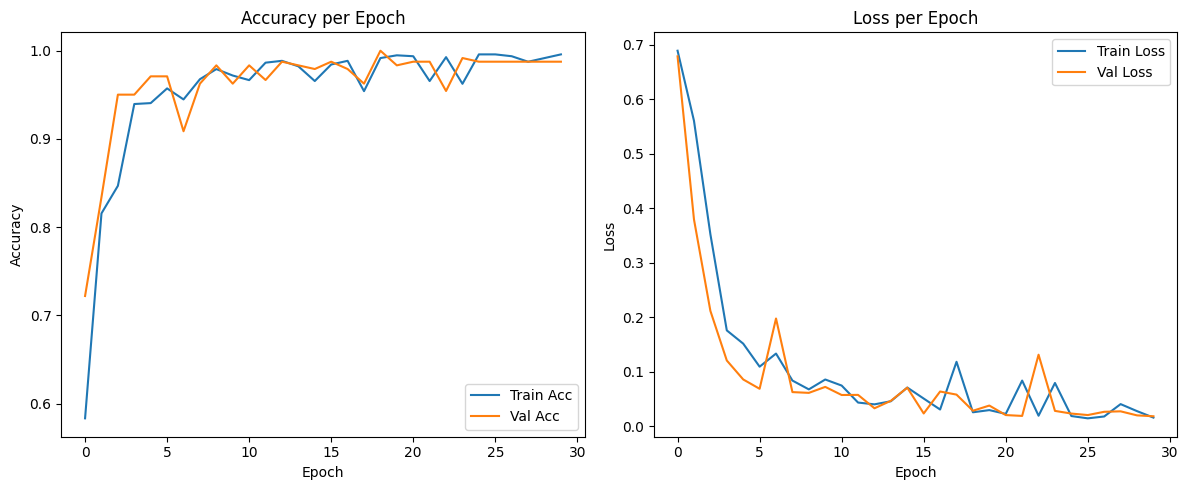

In [61]:
# ✅ Plot accuracy dan loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


8/8 [==============================] - 0s 2ms/step


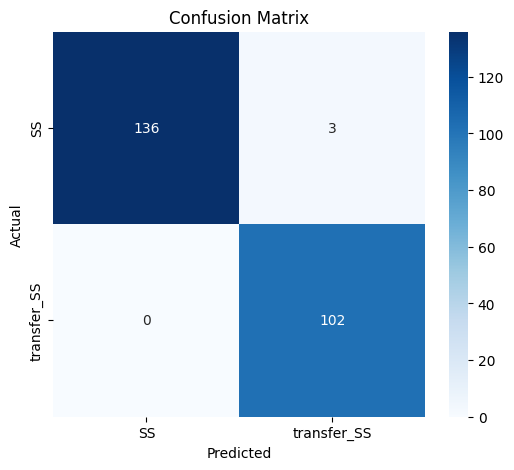

Accuracy: 98.76%
Precision: 98.79%
Recall: 98.76%
F1-score: 98.76%


In [62]:
# ✅ Confusion matrix dan evaluasi model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=le.classes_, output_dict=True)
accuracy = report['accuracy'] * 100
precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1 = report['weighted avg']['f1-score'] * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-score: {f1:.2f}%")


In [63]:
# ✅ (Opsional) Tampilkan metrik dalam format besar HTML
html = f"""
<h3><strong>Accuracy:</strong> {accuracy:.2f}%</h3>
<h3><strong>Precision:</strong> {precision:.2f}%</h3>
<h3><strong>Recall:</strong> {recall:.2f}%</h3>
<h3><strong>F1-score:</strong> {f1:.2f}%</h3>
"""
display(HTML(html))


In [64]:
# ✅ Simpan model
model.save("hand_gesture_model.h5")


d:\Tugas Akhir\Program\jupyter-hands-recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# ✅ Real-time prediksi gesture via webcam
model = tf.keras.models.load_model("hand_gesture_model.h5")
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.append(lm.x)
                landmarks.append(lm.y)
                landmarks.append(lm.z)
            landmarks = np.array(landmarks).reshape(1, 1, -1)
            prediction = model.predict(landmarks)
            class_index = np.argmax(prediction)
            class_label = le.inverse_transform([class_index])[0]
            cv2.putText(frame, class_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    cv2.imshow("Hand Gesture Recognition", frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 17ms/step
